# Predicting Network Anomalies: Model Evaluation

We use the data and the labels generated in step 1 to build and evaluate the performance of multiple models to predict network degradation as it is identified in the labels. 

## Imports

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime, timedelta

In [2]:
clean_data = pd.read_csv("clean_labeled.csv")

labels = clean_data["predictions"]
df = clean_data.drop(columns=['basic_ema_anomaly', 'dspot_anomaly', 'tuned_dspot_anomaly'])#, 'predictions'])

In [3]:
# hostdf = df[df['hostname'] == '33fe84e'].copy()
# hostdf["date"] = pd.to_datetime(hostdf["date"])
# hostdf = hostdf.sort_values(by='date', ascending=True)
# hostdf['time_diff'] = hostdf['date'] - (hostdf['date'].shift(1))
# mask = (hostdf['time_diff'] > timedelta(days=1)) #& hostdf['time_diff'] >= timedelta(hours=2, minutes=15))
# filtered_results = hostdf[mask]['time_diff'].value_counts()

# # filtered_results
# hostdf.iloc[420:].head(30)

# how this would look if we did it one by one



# X_potential = hostdf[['ping_latency', 'time_diff']]
# hostdf

Filtering out 10 Second Time Deltas

In [4]:
hostdf = df[df['hostname'] == '33fe84e'].copy()
hostdf["date"] = pd.to_datetime(hostdf["date"])
hostdf = hostdf.sort_values(by='date', ascending=True)
hostdf['time_diff'] = hostdf['date'] - (hostdf['date'].shift(1))
mask = (hostdf['time_diff'] >= timedelta(hours=2, minutes=15))
three_hour_filtered_results = hostdf[mask]['time_diff'].value_counts()
filtered_host_df = hostdf[mask]
# filtered_results
filtered_host_df.iloc[420:].head(30)
# three_hour_filtered_results

,Unnamed: 0,hostname,date,ping_jitter,ping_latency,ping_low,ping_high,day,predictions,time_diff
21882,35139,33fe84e,2025-07-14 18:00:23,0.722,13.150,12.595,14.107,2025-07-14,False,0 days 02:59:49
21950,35236,33fe84e,2025-07-14 21:00:29,1.173,13.512,11.624,14.046,2025-07-14,False,0 days 02:59:36
22038,35372,33fe84e,2025-07-15 00:00:34,1.427,13.321,11.861,14.713,2025-07-15,False,0 days 03:00:00
22085,35425,33fe84e,2025-07-15 03:00:30,0.512,13.398,11.555,13.469,2025-07-15,False,0 days 02:59:50
22150,35516,33fe84e,2025-07-15 06:00:33,2.383,13.018,8.942,13.590,2025-07-15,False,0 days 02:59:48
22235,35630,33fe84e,2025-07-15 09:00:34,3.332,11.677,7.729,14.410,2025-07-15,False,0 days 02:59:46
22317,35743,33fe84e,2025-07-15 12:00:46,1.338,13.229,12.308,14.244,2025-07-15,False,0 days 03:00:12
22341,35783,33fe84e,2025-07-15 15:00:29,1.115,13.186,9.534,13.400,2025-07-15,False,0 days 02:59:43
22400,35865,33fe84e,2025-07-15 18:00:24,0.377,13.268,12.607,13.670,2025-07-15,False,0 days 02:59:36
22464,35954,33fe84e,2025-07-15 21:00:20,0.927,13.178,12.194,14.028,2025-07-15,False,0 days 02:59:34


In [5]:
#across host names
hostnames = df["hostname"].unique().tolist()
hostnames

['9cd30bf',
 'b340432',
 '9dc32f2',
 '33fe84e',
 '592a43c',
 '38b6bf0',
 'b5c8445',
 '953d46d',
 '7f6d63d',
 'b2c53ee',
 'b407ebe',
 '5bf17fc',
 '8445893',
 '5c5004f',
 '6ca8355',
 'f8f4b44',
 'd493afd',
 'dede9dc',
 '9ab8252',
 '43e847f',
 'da6d469',
 'ed86ea2',
 '1a21874',
 '25b3303',
 '0f42441',
 '7677030',
 'a2e0486',
 'be83e98',
 '2620a05',
 'c073f39',
 '9840de6',
 '64b750b',
 '63598f8',
 '116259b',
 '09ccf4b',
 '575f518',
 '29129b6',
 '24a22bf',
 '972f622']

In [6]:
time_filtered_df = [] 
for host in hostnames:
    hostdf = df[df['hostname'] == host].copy()
    hostdf["date"] = pd.to_datetime(hostdf["date"])
    hostdf = hostdf.sort_values(by='date', ascending=True)
    hostdf['time_diff'] = hostdf['date'] - (hostdf['date'].shift(1))
    mask = (hostdf['time_diff'] >= timedelta(hours=2, minutes=15))
    three_hour_filtered_results = hostdf[mask]['time_diff'].value_counts()
    filtered_host_df = hostdf[mask]
    
    time_filtered_df.append(filtered_host_df)                  # collect
                                               
time_filtered_df = pd.concat(time_filtered_df, ignore_index=True)
time_filtered_df

,Unnamed: 0,hostname,date,ping_jitter,ping_latency,ping_low,ping_high,day,predictions,time_diff
0,9076,9cd30bf,2025-04-16 03:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
1,9121,9cd30bf,2025-04-16 06:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
2,9213,9cd30bf,2025-04-16 09:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
3,9255,9cd30bf,2025-04-16 12:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
4,9321,9cd30bf,2025-04-16 15:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
...,...,...,...,...,...,...,...,...,...,...
20213,44465,972f622,2025-07-31 09:00:25,1.505,14.082,12.842,16.411,2025-07-31,False,0 days 02:59:32
20214,44549,972f622,2025-07-31 12:00:29,2.347,15.704,13.681,17.824,2025-07-31,False,0 days 02:59:41
20215,44653,972f622,2025-07-31 15:00:38,2.939,16.813,13.849,19.617,2025-07-31,False,0 days 03:00:00
20216,44729,972f622,2025-07-31 18:00:32,0.737,22.073,21.614,22.988,2025-07-31,False,0 days 02:59:48


Normalize values per host

In [7]:
tdf = time_filtered_df #for ease of naming

Split into train and test before normalizing

In [8]:
start_a = pd.Timestamp("2025-04-16")
end_a   = pd.Timestamp("2025-06-20")

start_b = pd.Timestamp("2025-07-01")
end_b   = pd.Timestamp("2025-08-01")

mask_a = (tdf["date"] >= start_a) & (tdf["date"] <= end_a)
mask_b = (tdf["date"] >= start_b) & (tdf["date"] <= end_b)

train = tdf[mask_a].copy()
test = tdf[mask_b].copy()

In [9]:
train

,Unnamed: 0,hostname,date,ping_jitter,ping_latency,ping_low,ping_high,day,predictions,time_diff
0,9076,9cd30bf,2025-04-16 03:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
1,9121,9cd30bf,2025-04-16 06:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
2,9213,9cd30bf,2025-04-16 09:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
3,9255,9cd30bf,2025-04-16 12:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
4,9321,9cd30bf,2025-04-16 15:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00
...,...,...,...,...,...,...,...,...,...,...
19965,25467,972f622,2025-06-19 09:00:28,2.876,17.381,13.894,19.814,2025-06-19,False,0 days 02:59:38
19966,25574,972f622,2025-06-19 12:00:33,1.648,16.016,12.872,17.600,2025-06-19,False,0 days 02:59:42
19967,25662,972f622,2025-06-19 15:00:31,1.283,17.178,14.950,17.797,2025-06-19,False,0 days 02:59:39
19968,25755,972f622,2025-06-19 18:00:42,2.826,16.741,13.816,18.750,2025-06-19,False,0 days 02:59:59


In [10]:
test

,Unnamed: 0,hostname,date,ping_jitter,ping_latency,ping_low,ping_high,day,predictions,time_diff
283,27531,9cd30bf,2025-07-01 00:00:41,4.890,13.842,12.322,22.158,2025-07-01,False,11 days 02:59:48
284,27595,9cd30bf,2025-07-01 03:00:54,4.890,13.842,12.322,22.158,2025-07-01,False,0 days 03:00:13
285,27672,9cd30bf,2025-07-01 06:00:33,4.890,13.842,12.322,22.158,2025-07-01,False,0 days 02:59:39
286,27794,9cd30bf,2025-07-01 09:00:41,4.890,13.842,12.322,22.158,2025-07-01,False,0 days 03:00:08
287,27892,9cd30bf,2025-07-01 12:00:31,4.890,13.842,12.322,22.158,2025-07-01,False,0 days 02:59:50
...,...,...,...,...,...,...,...,...,...,...
20213,44465,972f622,2025-07-31 09:00:25,1.505,14.082,12.842,16.411,2025-07-31,False,0 days 02:59:32
20214,44549,972f622,2025-07-31 12:00:29,2.347,15.704,13.681,17.824,2025-07-31,False,0 days 02:59:41
20215,44653,972f622,2025-07-31 15:00:38,2.939,16.813,13.849,19.617,2025-07-31,False,0 days 03:00:00
20216,44729,972f622,2025-07-31 18:00:32,0.737,22.073,21.614,22.988,2025-07-31,False,0 days 02:59:48


In [11]:
# TRAIN NORMALIZATION

#normalizing using Z-score for each hostname
train["normalized_latency"] = train.groupby("hostname")["ping_latency"] \
                   .transform(lambda x: (x - x.mean()) / x.std())
train["normalized_latency"] = train["normalized_latency"].fillna(0)
#subtracting by smallest Z-score such that normalized values are all positive
train["normalized_latency"] = train["normalized_latency"] - train["normalized_latency"].min()
# time_filtered_df[time_filtered_df["normalized_latency"] == 0]
train

,Unnamed: 0,hostname,date,ping_jitter,ping_latency,ping_low,ping_high,day,predictions,time_diff,normalized_latency
0,9076,9cd30bf,2025-04-16 03:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00,16.322154
1,9121,9cd30bf,2025-04-16 06:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00,16.322154
2,9213,9cd30bf,2025-04-16 09:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00,16.322154
3,9255,9cd30bf,2025-04-16 12:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00,16.322154
4,9321,9cd30bf,2025-04-16 15:00:30,1.824,15.667,12.622,17.349,2025-04-16,False,0 days 03:00:00,16.322154
...,...,...,...,...,...,...,...,...,...,...,...
19965,25467,972f622,2025-06-19 09:00:28,2.876,17.381,13.894,19.814,2025-06-19,False,0 days 02:59:38,15.232222
19966,25574,972f622,2025-06-19 12:00:33,1.648,16.016,12.872,17.600,2025-06-19,False,0 days 02:59:42,14.619799
19967,25662,972f622,2025-06-19 15:00:31,1.283,17.178,14.950,17.797,2025-06-19,False,0 days 02:59:39,15.141143
19968,25755,972f622,2025-06-19 18:00:42,2.826,16.741,13.816,18.750,2025-06-19,False,0 days 02:59:59,14.945078


In [12]:
#test normalization
#normalizing using Z-score for each hostname
test["normalized_latency"] = test.groupby("hostname")["ping_latency"] \
                   .transform(lambda x: (x - x.mean()) / x.std())
test["normalized_latency"] = test["normalized_latency"].fillna(0)
#subtracting by smallest Z-score such that normalized values are all positive
test["normalized_latency"] = test["normalized_latency"] - test["normalized_latency"].min()
# time_filtered_df[time_filtered_df["normalized_latency"] == 0]
test

,Unnamed: 0,hostname,date,ping_jitter,ping_latency,ping_low,ping_high,day,predictions,time_diff,normalized_latency
283,27531,9cd30bf,2025-07-01 00:00:41,4.890,13.842,12.322,22.158,2025-07-01,False,11 days 02:59:48,5.769273
284,27595,9cd30bf,2025-07-01 03:00:54,4.890,13.842,12.322,22.158,2025-07-01,False,0 days 03:00:13,5.769273
285,27672,9cd30bf,2025-07-01 06:00:33,4.890,13.842,12.322,22.158,2025-07-01,False,0 days 02:59:39,5.769273
286,27794,9cd30bf,2025-07-01 09:00:41,4.890,13.842,12.322,22.158,2025-07-01,False,0 days 03:00:08,5.769273
287,27892,9cd30bf,2025-07-01 12:00:31,4.890,13.842,12.322,22.158,2025-07-01,False,0 days 02:59:50,5.769273
...,...,...,...,...,...,...,...,...,...,...,...
20213,44465,972f622,2025-07-31 09:00:25,1.505,14.082,12.842,16.411,2025-07-31,False,0 days 02:59:32,5.096735
20214,44549,972f622,2025-07-31 12:00:29,2.347,15.704,13.681,17.824,2025-07-31,False,0 days 02:59:41,6.047676
20215,44653,972f622,2025-07-31 15:00:38,2.939,16.813,13.849,19.617,2025-07-31,False,0 days 03:00:00,6.697857
20216,44729,972f622,2025-07-31 18:00:32,0.737,22.073,21.614,22.988,2025-07-31,False,0 days 02:59:48,9.781674


Model Validation

In [13]:
import numpy as np

In [14]:
#Getting X and y
features = ["normalized_latency"]
X_train = np.array(train[features])
X_test = np.array(test[features])
y_train = np.array(train["predictions"].astype(int))
y_test = np.array(test["predictions"].astype(int))

In [15]:
#imports
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [16]:
#classifiers
model_dict = {
    "Linear Classifier (Logistic Regression)": LogisticRegression(random_state=0),
    "Nearest Neighbors": KNeighborsClassifier(3),
    "Linear SVM": SVC(kernel="linear", C=0.025, random_state=42),
    "RBF SVM": SVC(gamma=2, C=1, random_state=42),
   #"Gaussian Process": GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
   # "Neural Net": MLPClassifier(alpha=1, max_iter=100, random_state=42),
    "AdaBoost":AdaBoostClassifier(random_state=42),
    "Naive Bayes":GaussianNB(),
}
#https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [17]:

import matplotlib.pyplot as plt

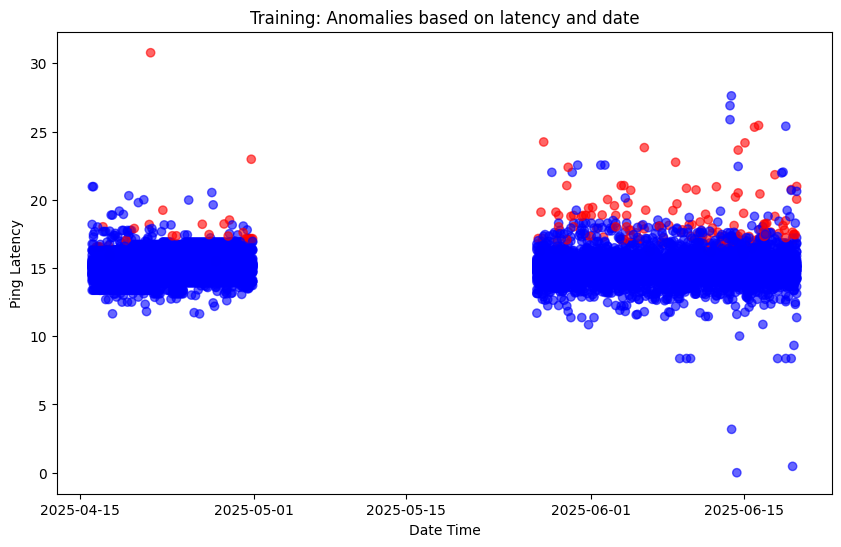

In [20]:
#for host name
plt.figure(figsize=(10, 6))
plt.title(f"Training: Anomalies based on latency and date")
plt.xlabel("Date Time")
plt.ylabel("Ping Latency")
plt.scatter(
    np.array(train["date"]), #may need to index
    np.array(X_train), 
    c=y_train,              # color by labels (1 or -1)
    cmap='bwr',             # blue = reg, red = anomalies
    alpha=0.6
)

# plt.legend()
# plt.savefig(f"plots/latency-date-normalized.png")
plt.show()

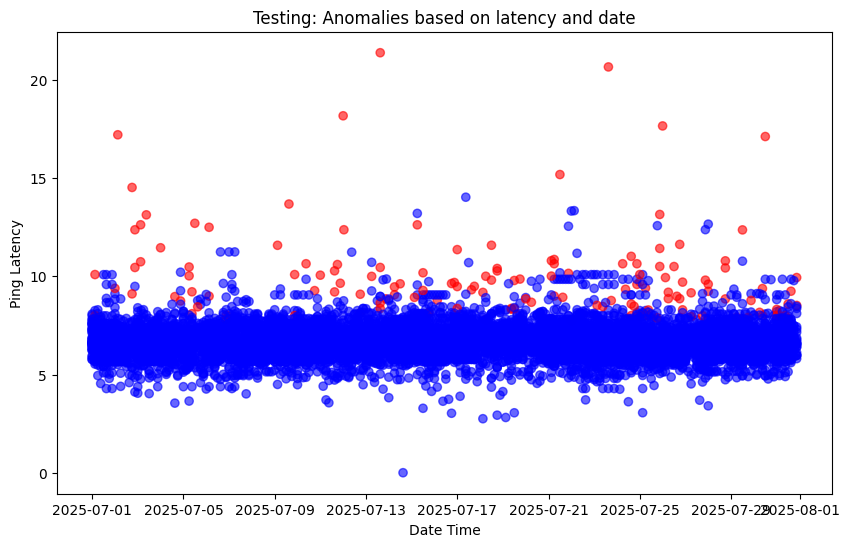

In [22]:
#for host name
plt.figure(figsize=(10, 6))
plt.title(f"Testing: Anomalies based on latency and date")
plt.xlabel("Date Time")
plt.ylabel("Ping Latency")
plt.scatter(
    np.array(test["date"]), #may need to index
    np.array(X_test), 
    c=y_test,              # color by labels (1 or -1)
    cmap='bwr',             # blue = reg, red = anomalies
    alpha=0.6
)

# plt.legend()
# plt.savefig(f"plots/latency-date-normalized.png")
plt.show()

Model Linear Classifier (Logistic Regression): Score 0.9834280303030303, F1 Score 0.5097102833492518, Percent Wrong Pred 0.016571969696969696
Model Nearest Neighbors: Score 0.9834280303030303, F1 Score 0.5097102833492518, Percent Wrong Pred 0.016571969696969696
Model Linear SVM: Score 0.9831912878787878, F1 Score 0.4957622060403486, Percent Wrong Pred 0.01680871212121212
Model RBF SVM: Score 0.9834280303030303, F1 Score 0.5097102833492518, Percent Wrong Pred 0.016571969696969696
Model Decision Tree: Score 0.9835464015151515, F1 Score 0.5165406491429231, Percent Wrong Pred 0.016453598484848484
Model Random Forest: Score 0.9834280303030303, F1 Score 0.5097102833492518, Percent Wrong Pred 0.016571969696969696
Model AdaBoost: Score 0.9835464015151515, F1 Score 0.5165406491429231, Percent Wrong Pred 0.016453598484848484
Model Naive Bayes: Score 0.015388257575757576, F1 Score 0.015244701737569422, Percent Wrong Pred 0.9846117424242424


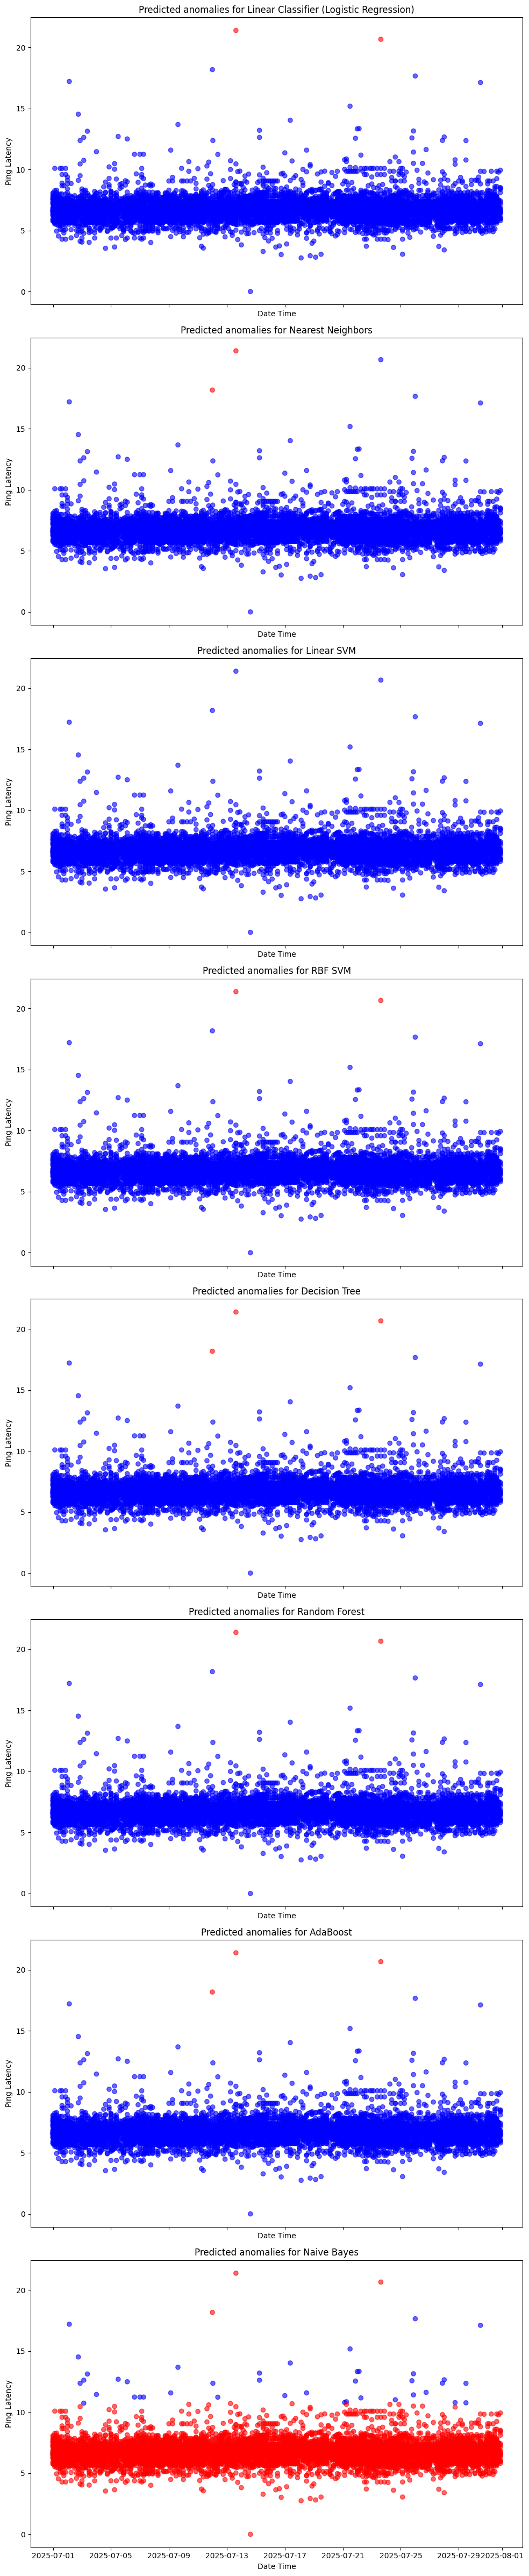

In [19]:
n_models = len(model_dict)
fig, axes = plt.subplots(nrows=n_models, ncols=1, figsize=(10, 6 * n_models), sharex=True)

# if only 1 model, axes is not an array
if n_models == 1:
    axes = [axes]

for ax, (model_name, clf) in zip(axes, model_dict.items()):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    per_wrong = abs(y_pred - y_test).sum() / len(y_test)

    print(f"Model {model_name}: Score {score}, F1 Score {f1}, Percent Wrong Pred {per_wrong}")

    # scatter plot on the current axis
    ax.scatter(
        np.array(test["date"]),  # x-axis
        np.array(X_test),        # y-axis
        c=y_pred,                # color by predicted label
        cmap='bwr',
        alpha=0.6
    )
    ax.set_title(f"Predicted anomalies for {model_name}")
    ax.set_xlabel("Date Time")
    ax.set_ylabel("Ping Latency")

plt.tight_layout()
plt.show()

*NOTES*: 

* the model isn't learning with multi-device (different ping latencies --> prediction basically random)

*TODO*: 
* feature importance